In [33]:
from torchvision.models import efficientnet_v2_s,EfficientNet_V2_S_Weights
from torch import nn
import torch
import torchvision

import matplotlib.pyplot as plt

from data_setup import create_dataloaders

In [3]:
weights = EfficientNet_V2_S_Weights.DEFAULT

model = efficientnet_v2_s(weights=weights)

In [4]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [5]:
# !pip install torchinfo

from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 384, 384),  # (batch_size, channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])



Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 384, 384]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 384, 384]     [1, 1280, 12, 12]    --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 384, 384]     [1, 24, 192, 192]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 384, 384]     [1, 24, 192, 192]    648                  True
│    │    └─BatchNorm2d (1)                                  [1, 24, 192, 192]    [1, 24, 192, 192]    48                   True
│    │    └─SiLU (2)                                         [1, 24, 192, 192]    [1, 24, 192, 192]    --                   --
│    └─Sequential (1)                                        [1, 24, 192, 192]    [1, 24, 192,

In [6]:
#freeeezing the base layers

for params in model.features.parameters():
    params.requires_grad=False

In [7]:
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 384, 384),  # (batch_size, channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 384, 384]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 384, 384]     [1, 1280, 12, 12]    --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 384, 384]     [1, 24, 192, 192]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 384, 384]     [1, 24, 192, 192]    (648)                False
│    │    └─BatchNorm2d (1)                                  [1, 24, 192, 192]    [1, 24, 192, 192]    (48)                 False
│    │    └─SiLU (2)                                         [1, 24, 192, 192]    [1, 24, 192, 192]    --                   --
│    └─Sequential (1)                                        [1, 24, 192, 192]    [1, 2

In [8]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [9]:

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True),
    nn.Linear(in_features=1280,out_features=3,bias=True)    
)


In [10]:
from torchinfo import summary
summary(model=model,
        input_size=(1, 3, 384, 384),  # (batch_size, channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 384, 384]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 384, 384]     [1, 1280, 12, 12]    --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 384, 384]     [1, 24, 192, 192]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 384, 384]     [1, 24, 192, 192]    (648)                False
│    │    └─BatchNorm2d (1)                                  [1, 24, 192, 192]    [1, 24, 192, 192]    (48)                 False
│    │    └─SiLU (2)                                         [1, 24, 192, 192]    [1, 24, 192, 192]    --                   --
│    └─Sequential (1)                                        [1, 24, 192, 192]    [1, 2

In [11]:
transform = weights.transforms()

transform

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
train_dir = "mini_food/pizza_steak_sushi/train"
test_dir = "mini_food/pizza_steak_sushi/test"


In [13]:
train_dataloader,test_dataloader, class_names = create_dataloaders(
   train_dir,
   test_dir,
   transform, 
)

In [14]:
class_names

['pizza', 'steak', 'sushi']

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),lr=0.001)

In [18]:
from timeit import default_timer as timer
from engine import train

torch.manual_seed(42)
torch.cuda.manual_seed(42)
start_time = timer()


device = "cuda" if torch.cuda.is_available() else "cpu"

results = train(model,optimizer,loss_fn,train_dataloader,test_dataloader,epochs=50,device=device)

end_time = timer()

print(f"[INFO] total time to train {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss: 1.0529 || Train Accuracy 52.08%
 Test Loss: 43.5227 || Test Accuracy 43.52%

Epoch: 1 | train_loss: 1.0529 | train_acc: 52.0833 | test_loss: 1.0665 | test_acc: 43.5227
 Train Loss: 1.0364 || Train Accuracy 45.83%
 Test Loss: 51.5909 || Test Accuracy 51.59%

Epoch: 2 | train_loss: 1.0364 | train_acc: 45.8333 | test_loss: 1.0507 | test_acc: 51.5909
 Train Loss: 1.0276 || Train Accuracy 60.00%
 Test Loss: 54.0909 || Test Accuracy 54.09%

Epoch: 3 | train_loss: 1.0276 | train_acc: 60.0000 | test_loss: 1.0383 | test_acc: 54.0909
 Train Loss: 1.0135 || Train Accuracy 62.50%
 Test Loss: 57.1591 || Test Accuracy 57.16%

Epoch: 4 | train_loss: 1.0135 | train_acc: 62.5000 | test_loss: 1.0385 | test_acc: 57.1591
 Train Loss: 0.9988 || Train Accuracy 60.83%
 Test Loss: 60.9091 || Test Accuracy 60.91%

Epoch: 5 | train_loss: 0.9988 | train_acc: 60.8333 | test_loss: 1.0119 | test_acc: 60.9091
 Train Loss: 0.9856 || Train Accuracy 66.67%
 Test Loss: 60.9091 || Test Accuracy 60.91%

Epoch

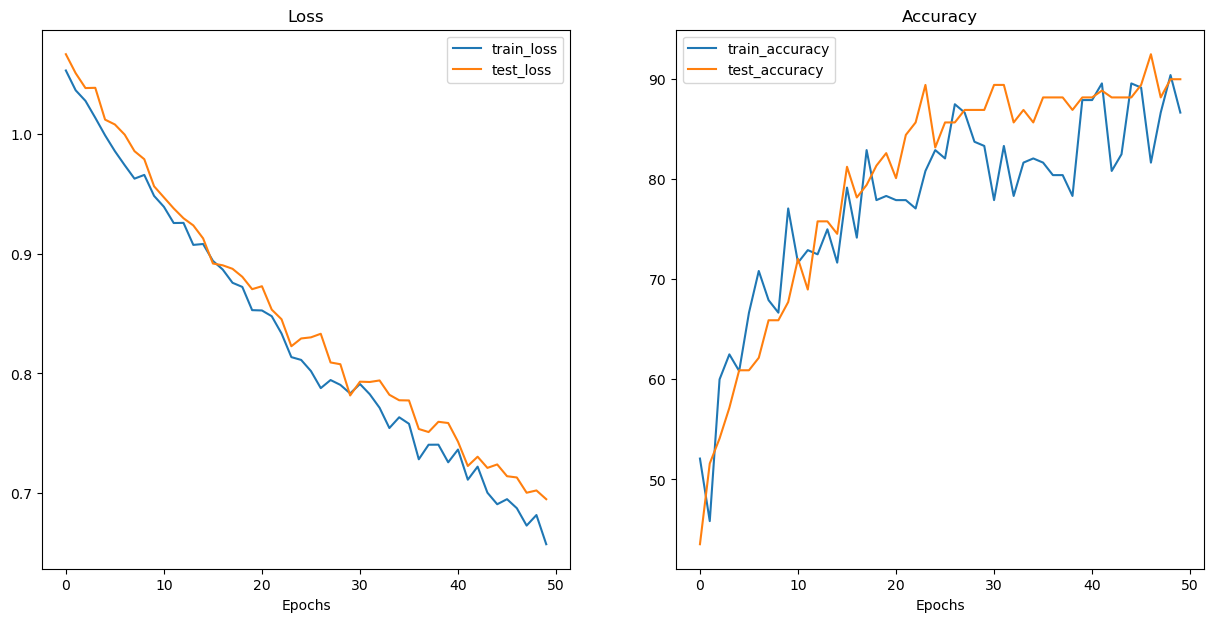

In [29]:
import utils

utils.plot_loss_curves(results)

In [34]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

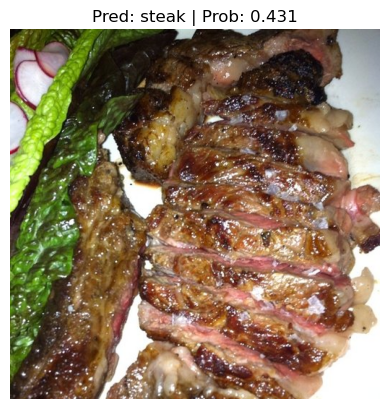

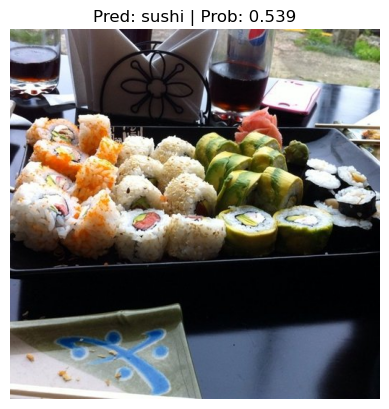

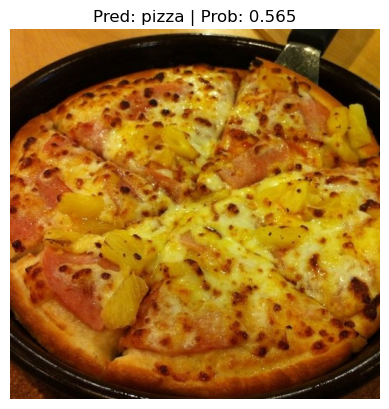

In [38]:
import random
from pathlib import Path
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))
